In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum,count,round , lit,when,substring,avg,countDistinct,floor,max,min
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import locale
import pandas as pd
import plotly.express as px
import time
import os

# Pré-processamento
from pyspark.ml.feature import StringIndexer, OneHotEncoder as OneHotEncoderSpark, VectorAssembler, MinMaxScaler as MinMaxScalerSpark
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Clusterização Hierárquica
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
# Clusterização K-Means
from sklearn.cluster import KMeans
# Métrica de qualidade de clusters
from sklearn.metrics import silhouette_score


caminho =r'D:/base_ans_parquet/'

anos_filtrar = ["2023", "2024", "2025"]

arquivos_parquet = [
    os.path.join(caminho, f)
    for f in os.listdir(caminho)
    if f.endswith(".parquet") and any(ano in f for ano in anos_filtrar)
]

spark = SparkSession.builder \
    .appName("LeituraParquet") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "8g") \
    .getOrCreate()
inicio = time.time()

spark.conf.set("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true")

df = spark.read.parquet(*arquivos_parquet)
total_registros = df.count()  # Força leitura e conta registros
fim = time.time()

print(f"Total de registros: {total_registros}")
print(f"Tempo de leitura: {fim - inicio:.2f} segundos")

Total de registros: 421212923
Tempo de leitura: 6.05 segundos


In [3]:
#FILTRAR DADOS
df_soma0 = df.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma0.show()
#FILTRAR APENAS USUARIOS DE PLANO DE SAUDE, EXCLUIR ODONTOLOGICO 
df_filtrado = df.filter(
    (col("COBERTURA_ASSIST_PLAN") == "Médico-hospitalar")     
)
df_soma = df_filtrado.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma.show()


#REMOVER USUARIOS SEM FAIXA ETARIA, SEM VINCULO
df_filtrado2345 = df_filtrado.filter(
    (col("DE_FAIXA_ETARIA") != "Informada Incorr") &
    (col("TIPO_VINCULO") != "Não Identificado") &
    (col("SG_UF") != "XX") &
    (col("DE_CONTRATACAO_PLANO") != "Não Identificado")
)
df_soma2 = df_filtrado2345.agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_total"))
#df_soma2.show()

df_filtrado6 = df_filtrado2345.filter(
    col("ID_CMPT_MOVEL").isin("2025-05")
)


df_somagroupby = df_filtrado6.groupBy("DE_FAIXA_ETARIA_REAJ", "TIPO_VINCULO").agg(sum("QT_BENEFICIARIO_ATIVO").alias("soma_valor"))

df_filtrado7 = df_filtrado6.filter(
    (col("ID_CMPT_MOVEL")=="2025-05") &
    (col("NM_RAZAO_SOCIAL")=="BRADESCO SAÚDE S.A." ) &
    (col("SG_UF").isin("PR"))
    
)

df_somagroupby.show(200)




+--------------------+------------+----------+
|DE_FAIXA_ETARIA_REAJ|TIPO_VINCULO|soma_valor|
+--------------------+------------+----------+
|        44 a 48 anos|     Titular|   3100206|
|        24 a 28 anos|     Titular|   2723753|
|        39 a 43 anos|  Dependente|   1479903|
|        29 a 33 anos|  Dependente|   1174542|
|        49 a 53 anos|  Dependente|    949867|
|          59 ou mais|  Dependente|   2312193|
|          59 ou mais|     Titular|   6066158|
|        19 a 23 anos|     Titular|   1593692|
|        39 a 43 anos|     Titular|   3621862|
|        24 a 28 anos|  Dependente|   1072228|
|        54 a 58 anos|  Dependente|    769314|
|         0 a 18 anos|  Dependente|  10023029|
|        44 a 48 anos|  Dependente|   1275434|
|        54 a 58 anos|     Titular|   1896262|
|         0 a 18 anos|     Titular|   1886454|
|        29 a 33 anos|     Titular|   3196199|
|        19 a 23 anos|  Dependente|   1576341|
|        34 a 38 anos|     Titular|   3489900|
|        49 a

In [4]:
qtde=df_filtrado7.count()
print ({qtde})

{23204}


In [5]:
# 4. Selecionar colunas numéricas e categóricas
col_numericas = [
    "QT_BENEFICIARIO_ATIVO",
    "QT_BENEFICIARIO_ADERIDO",
    "QT_BENEFICIARIO_CANCELADO"
]
col_categoricas = [
    "TIPO_VINCULO",
    "DE_FAIXA_ETARIA",
    "TP_SEXO",
    "DE_CONTRATACAO_PLANO"
]

# 5. StringIndexer + OneHotEncoder para cada coluna categórica
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx") for col in col_categoricas]

# OneHotEncoder para múltiplas colunas (PySpark 4.0)
encoder = OneHotEncoderSpark(
    inputCols=[f"{col}_idx" for col in col_categoricas],
    outputCols=[f"{col}_vec" for col in col_categoricas],
    handleInvalid="keep"
)

# Pipeline de transformação
pipeline = Pipeline(stages=indexers + [encoder])
df_encoded = pipeline.fit(df_filtrado7).transform(df_filtrado7)

# Junta tudo num vetor de features
input_features = col_numericas + [f"{col}_vec" for col in col_categoricas]
assembler = VectorAssembler(inputCols=input_features, outputCol="features_raw")
df_vector = assembler.transform(df_encoded)

# Escalona com MinMaxScaler
scaler = MinMaxScalerSpark(inputCol="features_raw", outputCol="features_scaled")
df_scaled = scaler.fit(df_vector).transform(df_vector)

# Coleta os dados como vetores NumPy para clusterização fora do Spark
X = df_scaled.select("features_scaled").rdd.map(lambda row: row["features_scaled"].toArray()).collect()


Variância explicada total: 83.24%


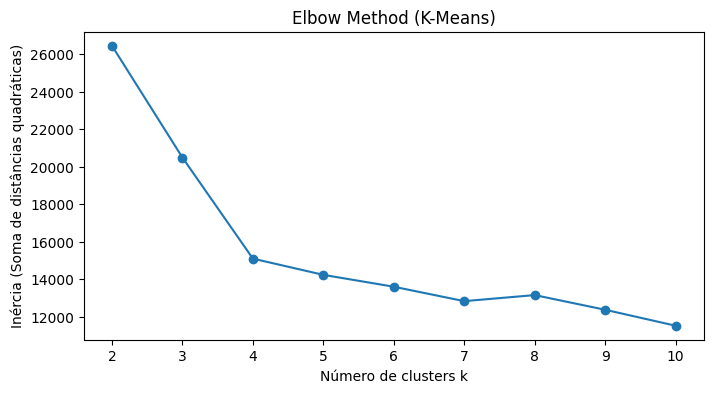

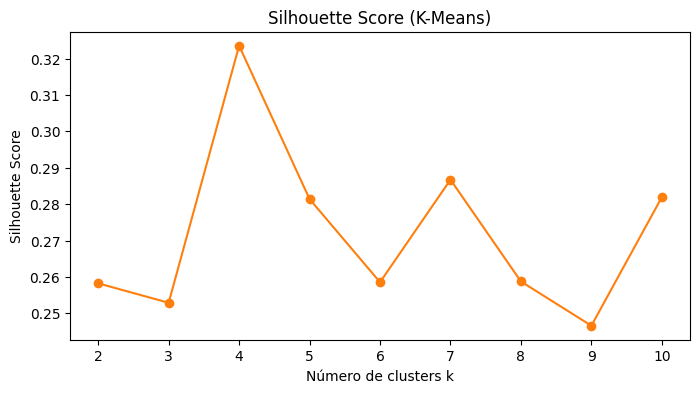

k ótimo pelo Silhouette Score: 4
K-Means k=4 → Inércia: 22865.575, Silhueta: 0.324



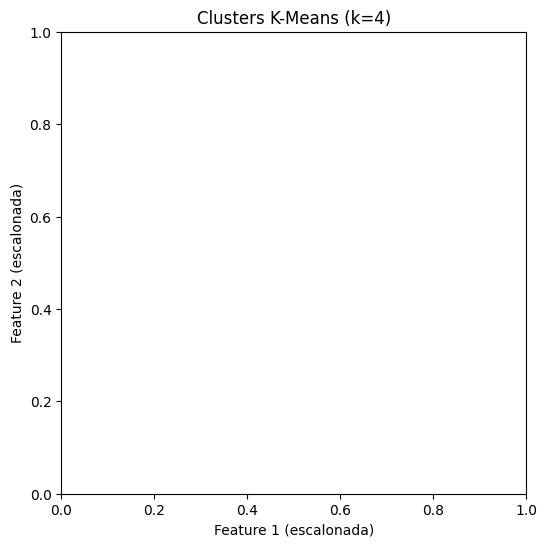

In [10]:
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Verifica quanta variância foi preservada
print(f"Variância explicada total: {np.sum(pca.explained_variance_ratio_):.2%}")


ks = range(2, 11)
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)                        # atributo inertia_ do KMeans
    silhouettes.append(silhouette_score(X, km_labels))  # silhueta para cada k

# 4.2. Plot do Método do Cotovelo (Inércia vs k)
plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, 'o-', color='C0')
plt.title('Elbow Method (K-Means)')
plt.xlabel('Número de clusters k')
plt.ylabel('Inércia (Soma de distâncias quadráticas)')
plt.show()

# 4.3. Plot dos Scores de Silhueta (Silhueta vs k)
plt.figure(figsize=(8, 4))
plt.plot(ks, silhouettes, 'o-', color='C1')
plt.title('Silhouette Score (K-Means)')
plt.xlabel('Número de clusters k')
plt.ylabel('Silhouette Score')
plt.show()

# 4.4. Seleção automática do k que maximiza o Silhouette Score
k_opt = ks[np.argmax(silhouettes)]
print(f"k ótimo pelo Silhouette Score: {k_opt}")

# 4.5. Ajuste final do modelo K-Means com o k ótimo
km_opt = KMeans(n_clusters=k_opt, random_state=42)
labels_km = km_opt.fit_predict(X)

# 4.6. Métricas para o modelo final
print(f"K-Means k={k_opt} → Inércia: {km_opt.inertia_:.3f}, "
      f"Silhueta: {silhouette_score(X, labels_km):.3f}\n")


# 4.7. Visualização dos clusters em 2D (duas primeiras features escalonadas)
plt.figure(figsize=(6, 6))
#plt.scatter(X[:, 0], X[:, 1], c=labels_km, cmap='tab10', s=10)
X = np.array(X)
plt.title(f'Clusters K-Means (k={k_opt})')
plt.xlabel('Feature 1 (escalonada)')
plt.ylabel('Feature 2 (escalonada)')
plt.show()

In [11]:
# Avalie diferentes números de clusters
range_n_clusters = range(2, 10)
silhouette_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(h_cluster, n_clusters, criterion='maxclust')
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.show()

NameError: name 'h_cluster' is not defined